# House Prices Prediction using TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the House Prices dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

## Import the library

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.11.0
TensorFlow Decision Forests v1.2.0


## Load the dataset


In [3]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)

In [4]:
dataset_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
dataset_df = dataset_df.drop('Id', axis=1)

## House Price Distribution

Now let us take a look at how the house prices are distributed.

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [6]:
list(set(dataset_df.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

In [7]:
dataset_df['YearsBtwRemod'] = dataset_df['YearRemodAdd']-dataset_df['YearBuilt']
dataset_df['TotalInnerSF'] = dataset_df['1stFlrSF']+dataset_df['2ndFlrSF']+dataset_df['TotalBsmtSF']
dataset_df['BedroomSize'] = round(dataset_df['1stFlrSF']+dataset_df['2ndFlrSF']/dataset_df['BedroomAbvGr'])

dataset_df.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset_df.BedroomSize.fillna(0,inplace=True)

In [8]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,YearsBtwRemod,TotalInnerSF,BedroomSize
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,2,2008,208500,0,2566,1141.0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,5,2007,181500,0,2524,1262.0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,9,2008,223500,1,2706,1209.0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,2,2006,140000,55,2473,1213.0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,12,2008,250000,0,3343,1408.0


In [9]:
df_num.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'YearsBtwRemod', 'TotalInnerSF',
       'BedroomSize'],
      dtype='object')

In [10]:
df_num

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,YearsBtwRemod,TotalInnerSF,BedroomSize
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,2,2008,208500,0,2566,1141.0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,5,2007,181500,0,2524,1262.0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,9,2008,223500,1,2706,1209.0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,2,2006,140000,55,2473,1213.0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,12,2008,250000,0,3343,1408.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,0,8,2007,175000,1,2600,1184.0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,0,0,0,2,2010,210000,10,3615,2073.0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,0,0,2500,5,2010,266500,65,3492,1476.0
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0,0,0,0,4,2010,142125,46,2156,1078.0


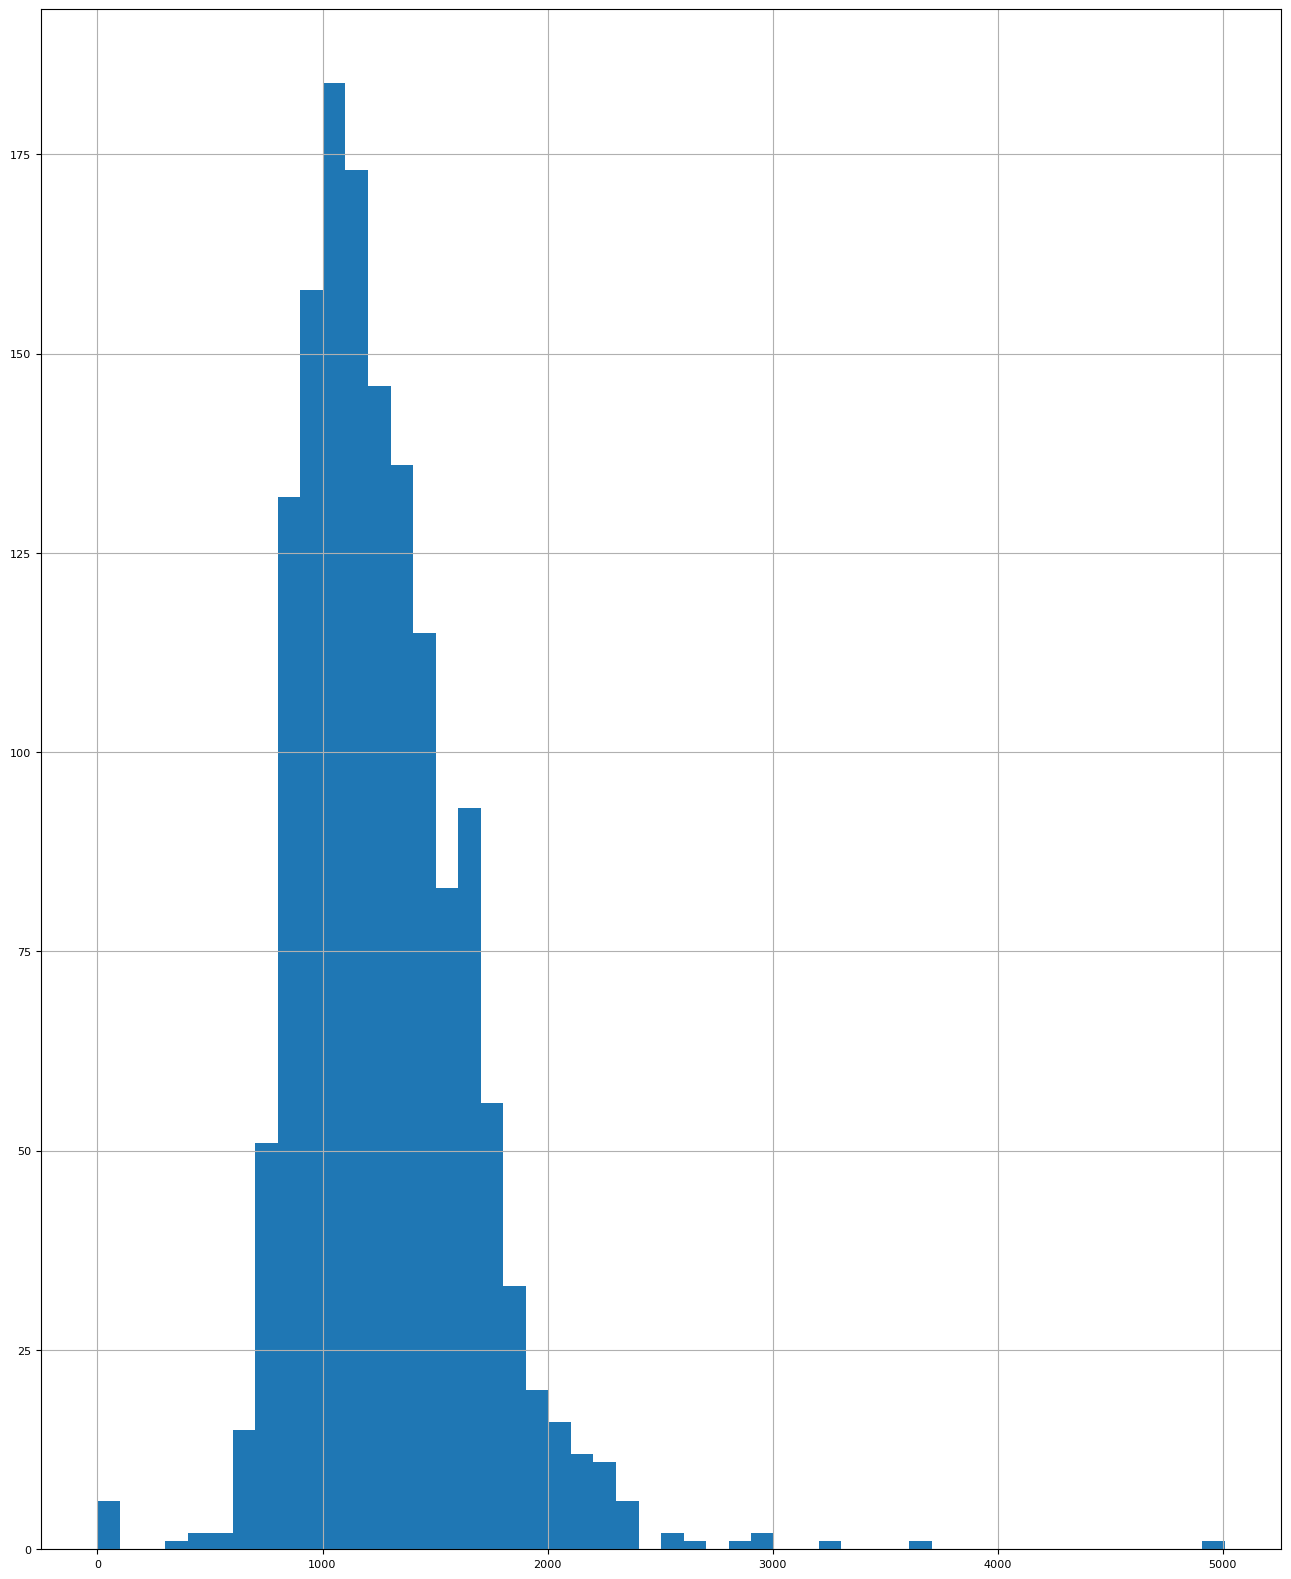

In [11]:
df_num.BedroomSize.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Now let us plot the distribution for all the numerical features.

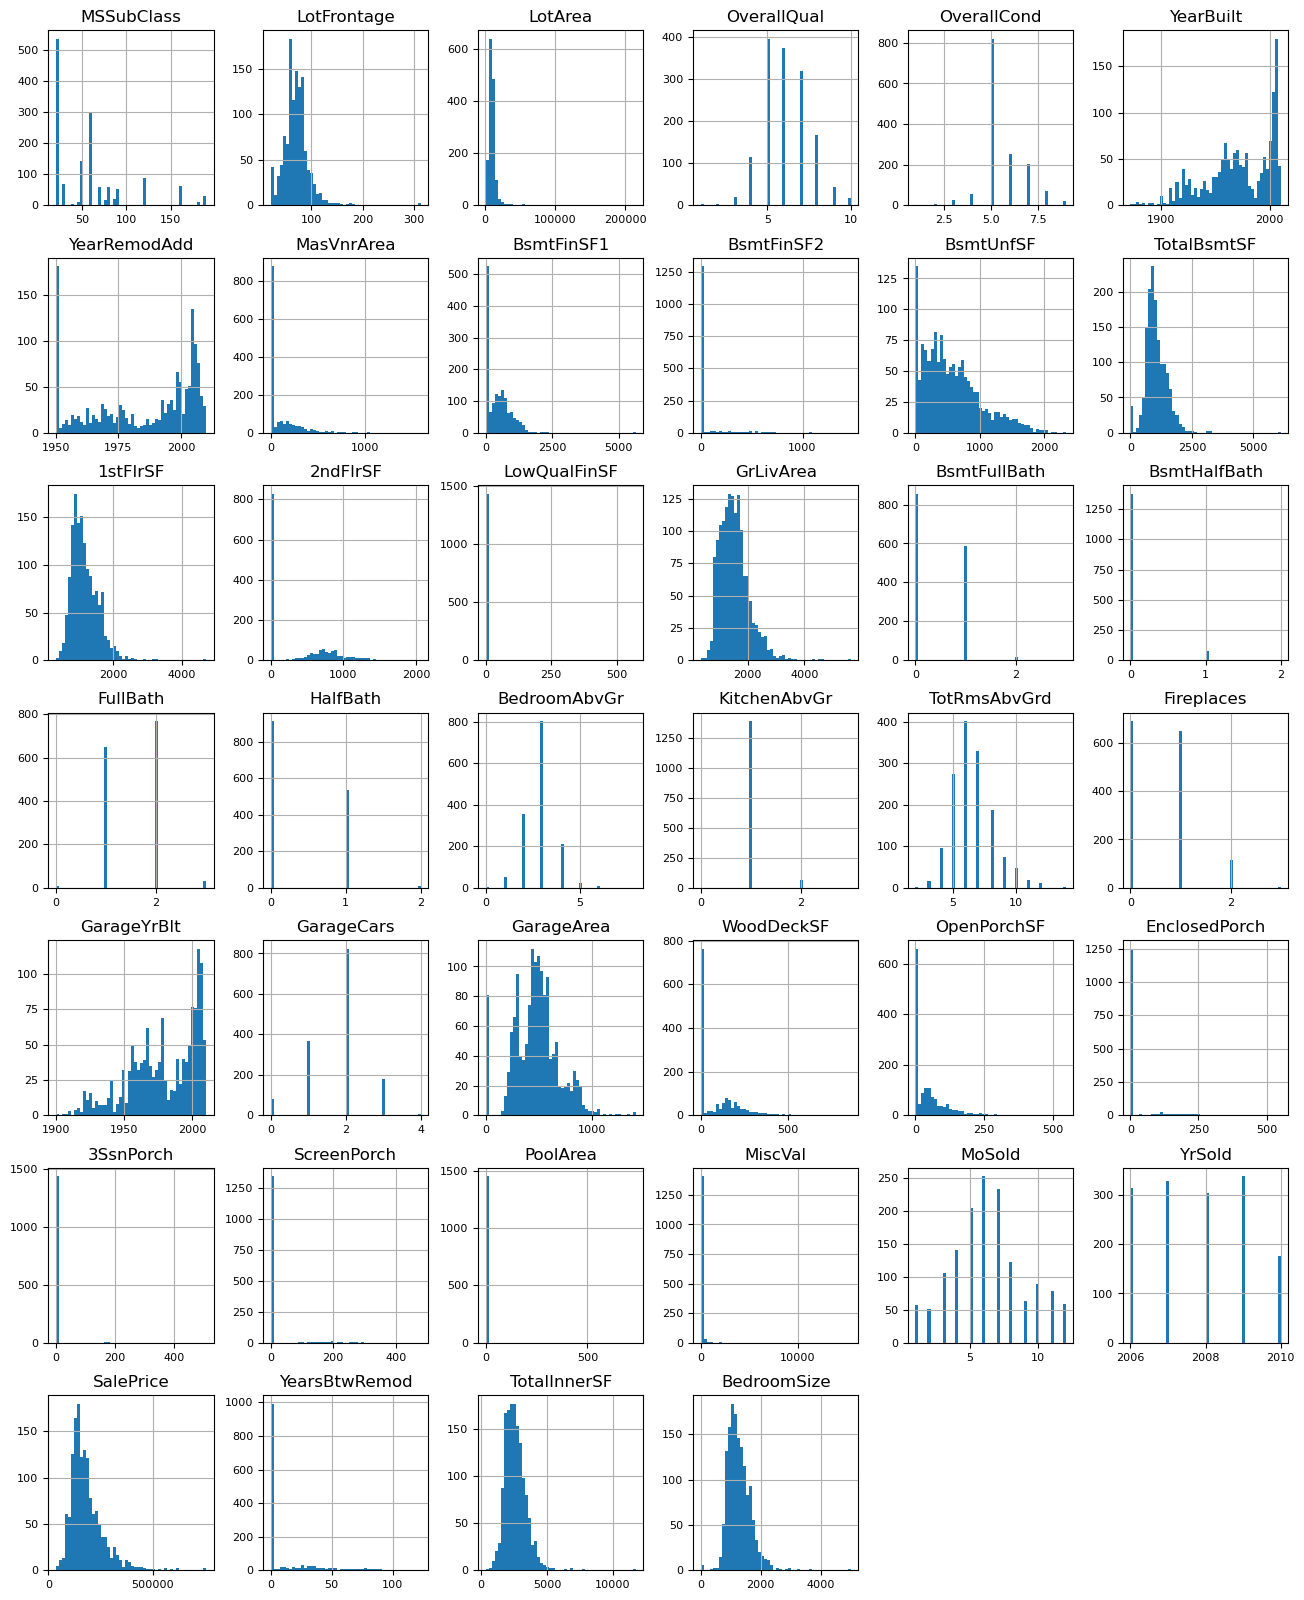

In [12]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Prepare the dataset

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

Now let us split the dataset into training and testing datasets:

In [13]:
import numpy as np

def split_dataset(dataset, test_ratio=0.28):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1042 examples in training, 418 examples in testing.


There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.

In [14]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

## Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [15]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

Hyperparameter Tuning

In [16]:
tuner = tfdf.tuner.RandomSearch(num_trials=30)

# Hyper-parameters to optimize.
tuner.choice("max_depth", [4,5,6,7,15,60,150])
tuner.choice("min_examples", [2,4,5,6,7,15,50,150])
tuner.choice("num_trees",[5,20,40,70,80,100,200,300])
tuner.choice("selective_gradient_boosting_ratio",[0.0001,0.01,0.015,0.02,0.025,0.1,0.7])
tuner.choice("random_seed",[123456,12,1717,654646])

## Create a Random Forest

Today, we will use the defaults to create the Random Forest Model while specifiyng the task type as `tfdf.keras.Task.REGRESSION`.

In [17]:
gbtm = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION, tuner=tuner)
gbtm.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmpm_mevp9r as temporary training directory


## Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [18]:
gbtm.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:07.484638. Found 1042 examples.
Training model...
Model trained in 0:00:12.673969
Compiling model...


[INFO 2024-03-06T01:55:30.195185993+00:00 kernel.cc:1214] Loading model from path /tmp/tmpm_mevp9r/model/ with prefix cd121a27461a4301
[INFO 2024-03-06T01:55:30.200850928+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2024-03-06T01:55:30.200992308+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


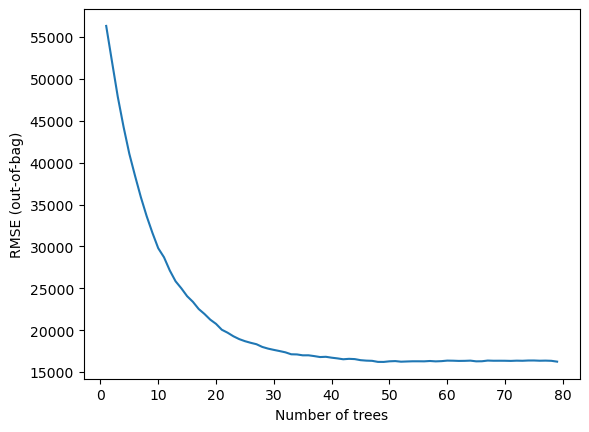

In [19]:
import matplotlib.pyplot as plt
logs = gbtm.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [20]:
inspector = gbtm.make_inspector()
inspector.evaluation()

Evaluation(num_examples=None, accuracy=None, loss=16211.611328125, rmse=16211.611328125, ndcg=None, aucs=None, auuc=None, qini=None)

Now, let us run an evaluation using the validation dataset.

In [21]:
evaluation = gbtm.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 728ms/step - loss: 0.0000e+00 - mse: 822613120.0000
loss: 0.0000
mse: 822613120.0000


## Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [22]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [23]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("TotalInnerSF" (1; #75), 9.0),
 ("OverallQual" (1; #63), 6.0),
 ("BsmtExposure" (4; #8), 4.0),
 ("Fireplaces" (1; #28), 4.0),
 ("Neighborhood" (4; #60), 4.0),
 ("GarageCars" (1; #33), 3.0),
 ("GrLivArea" (1; #39), 3.0),
 ("LotArea" (1; #48), 3.0),
 ("BsmtFinSF1" (1; #9), 2.0),
 ("OpenPorchSF" (1; #61), 2.0),
 ("SaleCondition" (4; #69), 2.0),
 ("GarageArea" (1; #32), 1.0),
 ("GarageYrBlt" (1; #38), 1.0),
 ("KitchenQual" (4; #45), 1.0),
 ("LotConfig" (4; #49), 1.0),
 ("SaleType" (4; #70), 1.0),
 ("WoodDeckSF" (1; #77), 1.0),
 ("YearRemodAdd" (1; #79), 1.0)]

Plot the variable importances from the inspector using Matplotlib

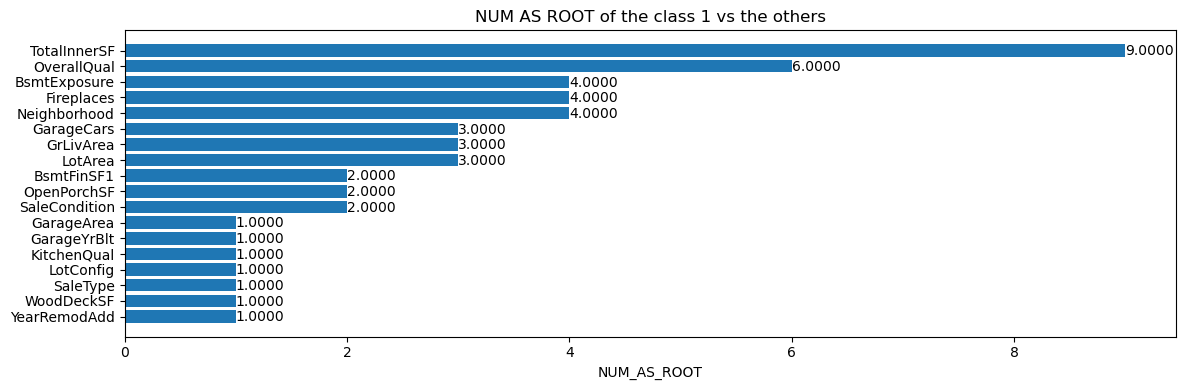

In [24]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()



# Submission
Finally predict on the competition test data using the model.

In [25]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)


test_data['YearsBtwRemod'] = test_data['YearRemodAdd']-test_data['YearBuilt']
test_data['TotalInnerSF'] = test_data['1stFlrSF']+test_data['2ndFlrSF']+test_data['TotalBsmtSF']
test_data['BedroomSize'] = round(test_data['1stFlrSF']+test_data['2ndFlrSF']/test_data['BedroomAbvGr'])

test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.BedroomSize.fillna(0,inplace=True)

ids = test_data.pop('Id')

In [26]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

In [27]:
preds = gbtm.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 16ms/step


,Id,SalePrice
0,1461,115997.710938
1,1462,154353.328125
2,1463,189610.578125
3,1464,189446.718750
4,1465,196754.546875


In [28]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = gbtm.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission6.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 17ms/step


,Id,SalePrice
0,1461,115997.710938
1,1462,154353.328125
2,1463,189610.578125
3,1464,189446.718750
4,1465,196754.546875
